## CLASS IMPLEMENTATIONS

In [1]:
'''
RUN ONLY ONCE OTHERWISE MULTIPLE LOGGER HANDLERS WILL BE ADDED
'''
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.')
logger.handlers

2016-11-16 10:39:38,519 - root - INFO - Logger works.


In [152]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.spatial.distance import euclidean
import time
import cPickle

In [153]:
def get_cfg(cfg_path_or_dict):
    if type(cfg_path_or_dict) == dict:
        return cfg_path_or_dict
    if not os.path.isfile(cfg_path_or_dict):
        raise ValueError('Config must be path to valid .yml file or dict.')
    with open(cfg_path_or_dict, 'rb') as f:
        cfg = yaml.load(f)
    return cfg

def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'wb') as f:
        return cPickle.load(self,f) 

In [51]:
class CaffeVectorsIterator(object):
    def __init__(self, file_path):
        log_pfx(self,'Reading Caffe Vector file %s...',file_path)
        self.f = open(file_path, 'rb')

    def next(self):
        try:
            # (id: int, vector: np array of float32)
            lineA = self.f.next()
            lineB = self.f.next()
            return (int(lineA.split(' ')[2]),  np.fromstring(lineB, dtype='f', sep=' '))
        except StopIteration:
            self.f.close()
            raise StopIteration

    def __del__(self):
        if self.f:
            self.f.close()


class CaffeVectorsIterable(object):
    def __init__(self, file_path):
        self.file_path = file_path

    def __iter__(self):
        return CaffeVectorsIterator(self.file_path)

In [157]:
class MultiHyperplanePartitioner(object):

    def __init__(self, cfg):
        if cfg:
            cfg = get_cfg(cfg)
            all_pivots=self.read_pivots(cfg)
            self.pivots, self.balance_score=self.select_top_k_pivots(all_pivots, int(cfg['base_sketch_length']))


    def save(self, file_path):
        to_save=self.pivots, self.balance_score
        save_to(to_save, file_path)

    @staticmethod
    def load(file_path, limit_pivots=None):
        if limit_pivots is not None:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s, limiting pivots count to %s...', file_path, limit_pivots )
        else:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s...',file_path)

        instance=MultiHyperplanePartitioner()
        tupl=load_from(file_path)
        if limit_pivots is None:
            instance.pivots=tupl[0]
            instance.balance_score=tupl[1]
        else:
            instance.pivots=tupl[0][:limit_pivots]
            instance.balance_score=tupl[1][:limit_pivots]
        return instance

    def select_top_k_pivots(self, all_pivots,k):
        log_pfx(self,'Selecting top %s pivots...',k)
        counters=[0]*len(all_pivots)
        n_obj=0
        t_start=time.time()
        for obj in CaffeVectorsIterable(cfg['dataset_path']):
            n_obj+=1
            if n_obj%10000==0:
                t_dur=time.time()-t_start
                t_start=time.time()
                log_pfx(self,'Adding counts for partitioning balance counter for dataset obj no. %s. Processing last 10000 objects took %ss...',n_obj,t_dur)
            for i, pivot_couple in enumerate(all_pivots):
                if self.get_partition(pivot_couple, obj)==1:
                    counters[i]+=1

        log_pfx(self,'Computing balance ratios and selecting top %s pivots...', k)
        balance_ratios=[abs(0.5-(float(count_1)/n_obj)) for i, count_1 in enumerate(counters)]
        sorted_pivots_with_ratings=sorted(zip(all_pivots, balance_ratios), key=lambda x: x[1])
        top_pivots, top_balance_score=zip(*[(tupl[0], tupl[1]) for tupl in sorted_pivots_with_ratings[:k]])
        return top_pivots, top_balance_score     

    def read_pivots(self, cfg):
        log_pfx(self,'Reading pivot file...')
        pivots = list()
        iterator = CaffeVectorsIterable(cfg['pivots_file_path']).__iter__()
        while True:
            try:
                pivot_A = iterator.next()
                pivot_B = iterator.next()
                pivots.append((pivot_A, pivot_B))
            except StopIteration:
                break
        return pivots


    def get_partition(self, pivot_couple, obj):
        distance_A = euclidean(obj[1], pivot_couple[0][1]) # pairwise returns matrix
        distance_B = euclidean(obj[1], pivot_couple[1][1])
        if distance_A > distance_B:
            return 0
        else:
            return 1

    def get_partitions(self, obj, index_mask=None):
        if not index_mask:
            index_mask=[True]*len(self.pivots)
        return [self.get_partition(pivot_couple, obj) for index, pivot_couple in enumerate(self.pivots) if index_mask[index]]

In [63]:
class SketchTrasformator(object):
def __init__(self, cfg):
    self.cfg=self.get_cfg(cfg, partitioner=None)
    if partitioner is None:
        self.partitioner=MultiHyperplanePartitioner(cfg)
    else:
        self.partitioner=partitioner
    dataset_iterator=CaffeVectorsIterable(cfg['dataset_path']).__iter__()
    #sketch_matrix=np.matrix([self.partitioner.get_partitions(data_record) for data_record in dataset_iterator])
    self.index_mask=generate_parition_index_mask(sketch_matrix, int(cfg['desired_sketch_length']))
    
def get_sketches(self,length):
    assert length<=len(self.partitioner.pivots)

def generate_partition_index_mask(self,sketch_matrix, desired_sketch_len):
    #if not enough pivots 
    pass
    
        

IndentationError: expected an indented block (<ipython-input-63-e2c5e1992b3c>, line 2)

## EXPERIMENTS

### Hyperplane partitioning

#### Balance score for 256 pivots

In [150]:
cfg={
    'pivots_file_path':'/home/kvassay/data/sketch-testing/pivots-random-2560.data',
    'base_sketch_length':1280,
    'dataset_path':'/home/kvassay/data/sketch-testing/profi-neuralnet-100K.data',
    'desired_sketch_length': 1280
}
t_start=time.time()
partitioner=MultiHyperplanePartitioner(cfg)
dur_s=time.time()-t_start
log_pfx(None,'Balanced pivot selection duration: %s', dur_s)

2016-11-16 11:51:24,244 - root - INFO - MultiHyperplanePartitioner| Reading pivot file...
2016-11-16 11:51:24,246 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/pivots-random-2560.data...
2016-11-16 11:51:26,601 - root - INFO - MultiHyperplanePartitioner| Selecting top 1280 pivots...
2016-11-16 11:51:26,602 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-11-16 12:01:43,007 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for dataset obj no. 10000. Processing last 10000 objects took 616.40549016s...
2016-11-16 12:11:57,079 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for dataset obj no. 20000. Processing last 10000 objects took 614.071527004s...
2016-11-16 12:22:08,407 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for datas

#### How balanced is Hyperplane partitioning with pivot couples (ordered by balance deviation)
We randomly selected over 1200 random pivot couples and ordered them according to how balanced is the data set if we partition it with Hyperplane partitioning using this couple. Balance deviation is from 0 to 0.5, 0 being perfectly balanced, 0.5 being only one partition contains objects. Deviation 0.1 means, that 40% of data set is in one partition and 60% in the other.

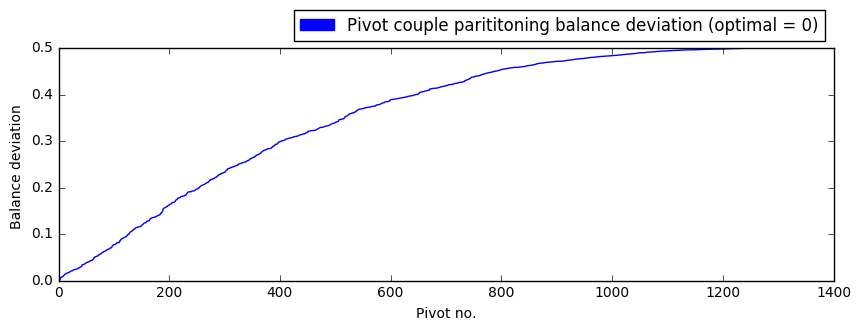

In [161]:
plt.figure(figsize=(10,3))
line=plt.plot(partitioner.balance_score, color='blue')
legend = mpatches.Patch(color='blue', label='Pivot couple parititoning balance deviation (optimal = 0)')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Pivot no.')
plt.ylabel('Balance deviation ')
plt.show()
# plt.figure(figsize=(5,5))
# line=plt.hist(partitioner.balance_score, color='blue', bins=len(partitioner.balance_score))
# logger.info(len(partitioner.balance_score))
# legend = mpatches.Patch(color='blue', label='Pivot couple parititoning balance score (optimal = 0)')
# plt.legend(handles=[legend])
# plt.show()